In [1]:
import datetime
import time
import numpy as np
import pandas as pd
from packaging import version
from collections import Counter
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
import string
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
!pip install -q -U keras-tuner
import keras_tuner as kt
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Input, Dense, Embedding, GlobalMaxPool1D
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, SimpleRNN, TextVectorization, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

tf.keras.utils.set_random_seed(7)
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)
pd.set_option('max_colwidth', 600)
#tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
#print("Device:", tpu.master())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
     |████████████████████████████████| 133 kB 5.9 MB/s 


In [2]:
!pip install tokenizers
!pip install transformers

from transformers import BertTokenizer
from tokenizers import BertWordPieceTokenizer
from transformers import TFBertModel, BertTokenizerFast 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.6 MB 11.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 14.4 MB/s 
     |████████████████████████████████| 84 kB 3.6 MB/s 
     |████████████████████████████████| 596 kB 65.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
pip install clean-text[gpl]


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 1.8 MB/s 
     |████████████████████████████████| 175 kB 23.8 MB/s 
     |████████████████████████████████| 235 kB 55.9 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=9ccc6f70db31095caa367aea541c5fabfc794a54cc0008b3374f2d720067f014
  Stored in directory: /root/.cache/pip/wheels/8a/4e/b6/57b01db010d17ef6ea9b40300af725ef3e210cb1acfb7ac8b6
Successfully built emoji


In [4]:
from cleantext import clean

In [5]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.8.0


In [6]:
print("Keras version: ", keras.__version__)

Keras version:  2.8.0


In [7]:
#mounting Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [8]:
#Read in data
path_to_csv = '/content/gdrive/My Drive/Colab Notebooks/MSDS_458_Assignment_4/cyberbullying_tweets.csv'
df=pd.read_csv(path_to_csv)

# Cleaning and Organizing Data

In [9]:
#looking at original data observation with emojis and urls

df.iloc[[706,1040]]

,tweet_text,cyberbullying_type
706,Uh. Why do they not make these for grownups? http://t.co/rHDOkljnDI,not_cyberbullying
1040,OMG 😱 I have a feeling I’m going to be overwhelmed 😱 by my emoticons in tomorrow’s #mkr 😱😰😅😜😀😩😨😱😱,not_cyberbullying


In [10]:
#function for cleaning data by removing emojies and urls with clean-text library. https://pypi.org/project/clean-text/

def cleaning_tweet_text(text):
    text= clean(text, no_emoji=True, no_urls=True, replace_with_url="",no_punct=True) #removing emojies and urls 
    return text



In [11]:
#applying cleaning function to tweets
df["tweet_text"]=df["tweet_text"].apply(cleaning_tweet_text)

In [12]:
#checking the same observations as above after removing emojies and urls. We can see there are no longer
#any emojies or urls
df.iloc[[706,1040]]

,tweet_text,cyberbullying_type
706,uh why do they not make these for grownups,not_cyberbullying
1040,omg i have a feeling im going to be overwhelmed by my emoticons in tomorrows mkr,not_cyberbullying


In [13]:
#dropping duplicates
df = df.drop_duplicates(subset=['tweet_text'], keep='last')
df.shape

(45502, 2)

In [14]:
#checking distribution of cyberbyllying lables.
df["cyberbullying_type"].value_counts()

religion               7961
age                    7935
ethnicity              7922
other_cyberbullying    7707
gender                 7631
not_cyberbullying      6346
Name: cyberbullying_type, dtype: int64

In [15]:
#creating column of numerical cyberbullying labels.

label_number_mappings={"religion":0,
                       "age":1,
                       "gender":2,
                       "ethnicity":3,
                       "not_cyberbullying":4,
                       "other_cyberbullying":5
                      }
df["label_values"]=df["cyberbullying_type"].map(label_number_mappings)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [16]:
#checking if mapping was properly done
df["label_values"].value_counts()

0    7961
1    7935
3    7922
5    7707
2    7631
4    6346
Name: label_values, dtype: int64

In [17]:
#Splitting dataset into full_train and test sets, stratifying on labels.

X_train_full, X_test, y_train_full, y_test = train_test_split(df["tweet_text"], df["label_values"], test_size=5000, stratify=df["label_values"])

In [18]:
#making sure full train set is stratified properly
y_train_full.value_counts()

0    7086
1    7063
3    7052
5    6860
2    6792
4    5649
Name: label_values, dtype: int64

In [19]:
#making sure test set is stratified properly
y_test.value_counts()

0    875
1    872
3    870
5    847
2    839
4    697
Name: label_values, dtype: int64

In [20]:
#spliting full training set into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_full,y_train_full, test_size=5000, stratify=y_train_full)

In [21]:
#making sure train set is stratified properly
y_train.value_counts()

0    6211
1    6191
3    6181
5    6013
2    5954
4    4952
Name: label_values, dtype: int64

In [22]:
#making sure validation set is stratified properly
y_val.value_counts()

0    875
1    872
3    871
5    847
2    838
4    697
Name: label_values, dtype: int64

# Helpful Model Fitting and Results Functions

In [23]:
#creating callback class to get the amount of seconds each epoch takes. Code from:
#https://stackoverflow.com/questions/43178668/record-the-computation-time-for-each-epoch-in-keras-during-model-fit

class EpochTimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)


In [24]:

def compile_train_model(model, x_train, y_train, x_valid, y_valid, model_num, epochs=100, patience=3, optimizer='adam'):
    timestamp=int(time.time())
    epoch_times=EpochTimeHistory()
  
    # Compile
    model.compile(optimizer=optimizer,
                loss = 'SparseCategoricalCrossentropy',
                metrics=['accuracy'])

  # Train
    start_time = time.time()
    history = model.fit(
      x_train,
      y_train,
      epochs=epochs,
      batch_size=128,
      validation_data=(x_valid, y_valid),
      verbose=1,
      callbacks=[    
          EarlyStopping(monitor='val_accuracy', patience=patience, restore_best_weights=True, verbose=0),
        
        epoch_times]
       )
    end_time = time.time()
    second_elapsed = round(end_time - start_time)
    epoch_times_values =epoch_times.times
    print("\n")
    print(f'Finished model training in {second_elapsed}s')
    print(f'Average time to run each epoch is: {  np.round(np.mean(epoch_times.times[1:-1]),4) }') 
                                                                       

    return history, model   

In [25]:
#Classificatin report function
def print_validation_report(test_labels, predictions):
    print("Classification Report")
    print(classification_report(test_labels, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(test_labels, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(test_labels, predictions))))#included per class instruction 

In [26]:
#function to print out training and validation set loss and accuracy values of the best model
def loss_accuracy_values(model_history, model_num, epochs, patience=3):  
  if len(model_history.history["val_loss"])==epochs:
      print("Model Experiment {} Training Loss: ".format(model_num),np.round(model_history.history["loss"][-1],4))
      print("Model Experiment {} Training Accuracy: ".format(model_num),np.round(model_history.history["accuracy"][-1],4))
      print("Model Experiment {}  Validation Loss: ".format(model_num),np.round(model_history.history["val_loss"][-1],4))
      print("Model Experiment {}  Validation Accuracy: ".format(model_num),np.round(model_history.history["val_accuracy"][-1],4))
  else:
      print("Model Experiment {}  Training Loss: ".format(model_num),np.round(model_history.history["loss"][-(1+patience)],4))
      print("Model Experiment {}  Training Accuracy: ".format(model_num),np.round(model_history.history["accuracy"][-(1+patience)],4))
      print("Model Experiment {}  Validation Loss: ".format(model_num), np.round(model_history.history["val_loss"][-(1+patience)],4))
      print("Model Experiment {}  Validation Accuracy:".format(model_num), np.round(model_history.history["val_accuracy"][-(1+patience)],4)) 

In [27]:
#creating function for charts of train vs validation accuracy and loss functions
def train_val_accuracy_and_loss_charts(model_history, model_num):
    model_df=pd.DataFrame(model_history.history)

    model_df[["loss","val_loss"]].plot(figsize=(9,7))
    plt.grid(True)
    plt.title("Model Experiment {}: Train vs. Validation - Loss".format(model_num), size =17)
    plt.xlabel("Epochs", size=15)

    model_df[["accuracy","val_accuracy"]].plot(figsize=(9,7))
    plt.grid(True)
    plt.title("Model Experiment {}: Train vs. Validation - Accuracy".format(model_num), size =17)
    plt.xlabel("Epochs", size=15)

    plt.show()    

In [28]:
# Function for creating multi-class confusion matrix

#class names for confusion matrix
class_names = ["religion",
                       "age",
                       "gender",
                       "ethnicity",
                       "not_cyberbullying",
                       "other_cyberbullying"
]



def confusion_matrix_multi_class(model_for_matrix,test_set, actual_test_labels, model_num):
    #predicting test set with model for confusion matrix and setting as sparse with argmax
    confusion_matrix_predictions=model_for_matrix.predict(test_set).argmax(axis=1)



    #creating confusion matrix - using test set labels as they were already sparse before one-hot encoding
    confusion_matrix_for_model = confusion_matrix( actual_test_labels ,  confusion_matrix_predictions)


    confusion_matrix_df = pd.DataFrame(confusion_matrix_for_model,
                    
                     index=class_names,
                     columns=class_names)

    #Plotting the confusion matrix
    plt.figure(figsize=(10,8))
    sns.heatmap(confusion_matrix_df, annot=True, fmt="d", cmap="rocket_r")
    plt.title('Confusion Matrix - Model Experiment {}'.format(model_num), size=17)
    plt.ylabel('Actual Labels', size=15)
    plt.xlabel('Predicted Labels',size=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.show()

In [29]:
keras.backend.clear_session()

# BERT Data Preprocessing and Tokenization

In [30]:
#Getting pretrained model and tokenizer
bert = TFBertModel.from_pretrained("bert-base-uncased") 
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased") 

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [31]:
#Tokenizing training, validation and test tweet text.
X_train_tokenized=tokenizer.batch_encode_plus(list(X_train), return_tensors="tf", max_length=70,truncation=True, padding='max_length')
X_val_tokenized=tokenizer.batch_encode_plus(list(X_val), return_tensors="tf", max_length=70,truncation=True, padding='max_length')
X_test_tokenized=tokenizer.batch_encode_plus(list(X_test), return_tensors="tf", max_length=70,truncation=True, padding='max_length')

In [32]:
#making numpy arrays from the train, validaion and test labels.
y_train=np.array(y_train)
y_val=np.array(y_val)
y_test=np.array(y_test)

In [33]:
#getting tokens and masks from the BERT tokenized train, validation and test sets.

train_tokens = X_train_tokenized["input_ids"]
train_masks = X_train_tokenized["attention_mask"]

val_tokens = X_val_tokenized["input_ids"]
val_masks = X_val_tokenized["attention_mask"]

test_tokens = X_test_tokenized["input_ids"]
test_masks = X_test_tokenized["attention_mask"]

# Experiment 8 - BERT pre-trained followed by 2 Dense Layers - Hyperparemeter Tunning

In [34]:
#model code modified from Yildirim and Asagri-Chenaghlu (2021). 
#Yildirim, Savas, and Meysam Asgari-Chenaghlu. 2021. Mastering Transformers. 1st edition. Packt Publishing.
max_length = 70 

def create_model_exp_8(hp): 

    #multiples of 32.
    #For both dense layears testing for a min of 32 nodes, a max of 256 filters and any in between by 
    #multiples of 32.
    dense_dim_1=hp.Int('Dense Layer 1 # of Dense Nodes',min_value=32, max_value=256, step =32)
    dense_dim_2=hp.Int('Dense Layer 2 # of Dense Nodes',min_value=32, max_value=256, step =32)
    #For both dense layears testing for a Dropout of a min of 0.1, a max of 0.4 and any in between by 
    #multiples of 0.1
    dropout_1=hp.Float("Dropout_after Dense Layer 1", min_value=0.10, max_value=0.40, step=0.10)
    dropout_2=hp.Float("Dropout_after Dense Layer 2", min_value=0.10, max_value=0.40, step=0.10)

    tokens = keras.layers.Input(shape=(max_length,), dtype=tf.dtypes.int32) 
    masks = keras.layers.Input(shape=(max_length,), dtype=tf.dtypes.int32) 
    embedding_layer = bert.layers[0]([tokens,masks])[0][:,0,:] 
    dense_1= tf.keras.layers.Dense(units=dense_dim_1, activation="relu")(embedding_layer)
    dropout_1=tf.keras.layers.Dropout(dropout_1)(dense_1)
    dense_2= tf.keras.layers.Dense(units=dense_dim_2, activation="relu")(dropout_1)
    dropout_2=tf.keras.layers.Dropout(dropout_2)(dense_2)
    output = tf.keras.layers.Dense(units=6, activation="softmax")(dropout_2)  
    model = keras.Model([tokens,masks],output)
    model.layers[2].trainable = False

    #testing for optimizer choice of adam, sgd, or rmsprop
    model.compile(optimizer=hp.Choice("optimizer", ["adam", "sgd", "rmsprop"]), \
                                            loss="sparse_categorical_crossentropy", metrics=["accuracy"])

    return model



In [35]:
#creating Bayesian Optimization for KerasTuner
tuner_exp_8 = kt.BayesianOptimization(
    hypermodel=create_model_exp_8,
    objective="val_accuracy",
    max_trials=10,
    overwrite=True,
    
    directory='/content/gdrive/My Drive/Colab Notebooks/MSDS_458_Assignment_4/keras_tuner_out',
    project_name="exp_8")

In [36]:
#setting epochs, patience and early stopping
epochs=30
patience=4
model_number="8"
early_stopping= EarlyStopping(monitor='val_accuracy',patience=patience, restore_best_weights=True )

#tunning the model
tuner_exp_8.search([train_tokens,train_masks], y_train, epochs=epochs, batch_size=128, validation_data=([val_tokens,val_masks], y_val), callbacks= [early_stopping])

Trial 10 Complete [00h 25m 26s]
val_accuracy: 0.8352000117301941

Best val_accuracy So Far: 0.8366000056266785
Total elapsed time: 03h 29m 36s
INFO:tensorflow:Oracle triggered exit


In [37]:
#getting best hyperparameters for model 
best_hyper_parameters_exp_8=tuner_exp_8.get_best_hyperparameters(num_trials=1)[0]

#function to print out best parameters depending on how many Conv layers there are
def best_model_hyperparameters_8(bhp):
    
    print("Dense Layer 1 # of Dense Nodes : {}".format(bhp.get("Dense Layer 1 # of Dense Nodes")))
    print("\n")
    print("Dense Layer 2 # of Dense Nodes : {}".format(bhp.get("Dense Layer 2 # of Dense Nodes")))
    print("\n")
    print('Dropout After Dense Layer 1:', np.round(bhp.get('Dropout_after Dense Layer 1'),3))
    print("\n")
    print('Dropout After Dense Layer 2:', np.round(bhp.get('Dropout_after Dense Layer 2'),3))
    print("\n")
    print("Optimizer Used: {}".format(bhp.get('optimizer')))                                                           

#printing out best model hyperparameters
best_model_hyperparameters_8(best_hyper_parameters_exp_8)  

Dense Layer 1 # of Dense Nodes : 256


Dense Layer 2 # of Dense Nodes : 32


Dropout After Dense Layer 1: 0.1


Dropout After Dense Layer 2: 0.1


Optimizer Used: rmsprop


In [38]:

#getting paremeters of best model
model_exp_8_best_params = tuner_exp_8.get_best_hyperparameters(2)

# Building model exp_8 with best hyper parameters
model_exp_8_best = create_model_exp_8(model_exp_8_best_params[0])


# Running best model 8 to get the time to run an epoch and time to run the whole model. Test set metrics will be 
#based of this model run.
epochs=30
patience=4
model_number="8"
history_exp_8, model_exp_8 = compile_train_model(model_exp_8_best,[train_tokens,train_masks],y_train,
                                    [val_tokens,val_masks],y_val, model_number, epochs,patience=patience,
                                    optimizer="rmsprop")

Epoch 1/30
278/278 [==============================] - 89s 254ms/step - loss: 0.8760 - accuracy: 0.6731 - val_loss: 0.7315 - val_accuracy: 0.7362
Epoch 2/30
278/278 [==============================] - 68s 244ms/step - loss: 0.6700 - accuracy: 0.7493 - val_loss: 0.5996 - val_accuracy: 0.7814
Epoch 3/30
278/278 [==============================] - 68s 244ms/step - loss: 0.6193 - accuracy: 0.7661 - val_loss: 0.5803 - val_accuracy: 0.7820
Epoch 4/30
278/278 [==============================] - 68s 244ms/step - loss: 0.5941 - accuracy: 0.7753 - val_loss: 0.5319 - val_accuracy: 0.8082
Epoch 5/30
278/278 [==============================] - 68s 243ms/step - loss: 0.5682 - accuracy: 0.7852 - val_loss: 0.5489 - val_accuracy: 0.7968
Epoch 6/30
278/278 [==============================] - 68s 245ms/step - loss: 0.5574 - accuracy: 0.7902 - val_loss: 0.4957 - val_accuracy: 0.8142
Epoch 7/30
278/278 [==============================] - 68s 244ms/step - loss: 0.5420 - accuracy: 0.7954 - val_loss: 0.5295 - val_ac

In [39]:
model_exp_8.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 70)]         0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 70)]         0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  109482240   ['input_3[0][0]',                
                                thPoolingAndCrossAt               'input_4[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 70,                                          

In [40]:
#printing train and validation loss and accuracy for the model

loss_accuracy_values(history_exp_8, model_number, epochs, patience=patience)

Model Experiment 8  Training Loss:  0.496
Model Experiment 8  Training Accuracy:  0.8129
Model Experiment 8  Validation Loss:  0.4553
Model Experiment 8  Validation Accuracy: 0.834


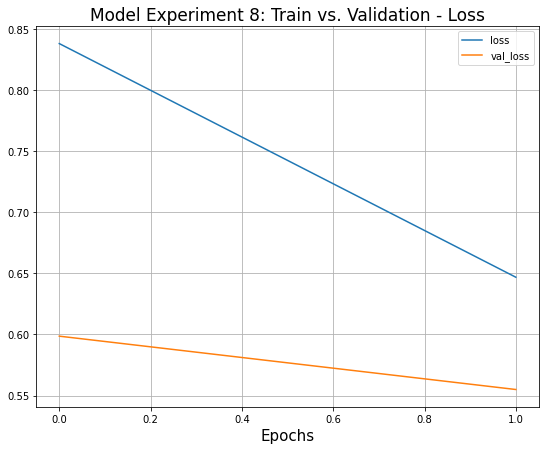

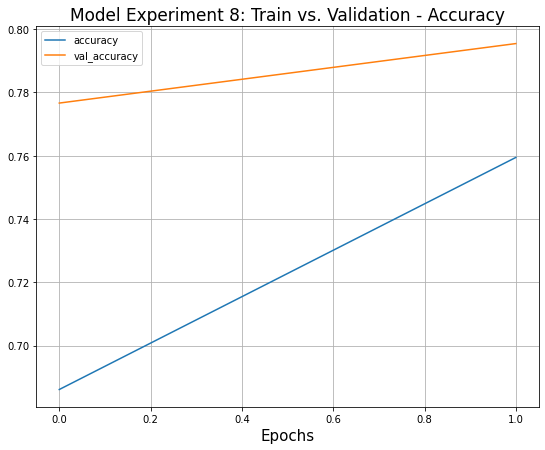

In [85]:
#printing charts of  train vs validation accuracy and loss functions

train_val_accuracy_and_loss_charts(history_exp_8, model_number)

In [41]:
#creating  classification report

#getting predictions

model_exp_8_predictions=model_exp_8.predict([[test_tokens,test_masks]]).argmax(axis=1)
print_validation_report(y_test, model_exp_8_predictions)

Classification Report
              precision    recall  f1-score   support

           0       0.92      0.93      0.92       875
           1       0.91      0.95      0.93       872
           2       0.79      0.84      0.81       839
           3       0.95      0.93      0.94       870
           4       0.70      0.53      0.60       697
           5       0.69      0.76      0.72       847

    accuracy                           0.83      5000
   macro avg       0.83      0.82      0.82      5000
weighted avg       0.83      0.83      0.83      5000

Accuracy Score: 0.8328
Root Mean Square Error: 0.9786725703727472


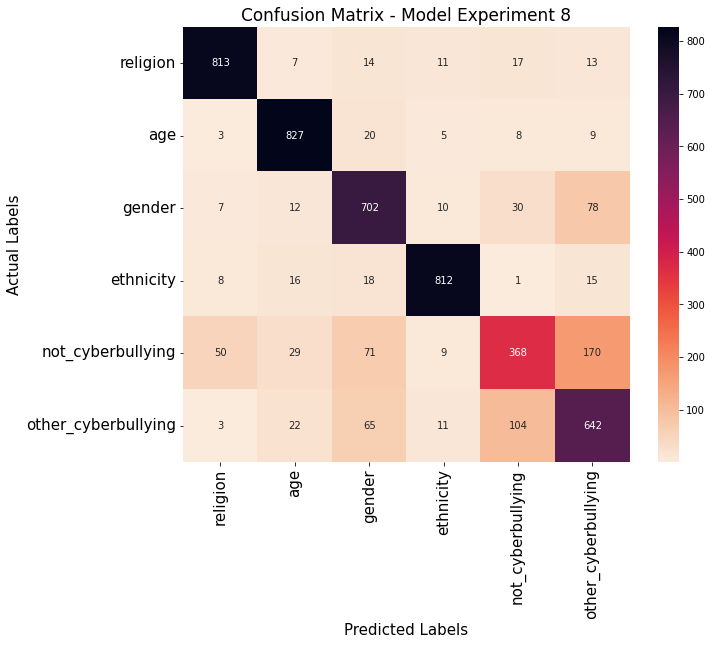

In [42]:
#printing out confusion matrix
confusion_matrix_multi_class(model_exp_8, [test_tokens,test_masks],y_test, model_number)